In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon':True})

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor

from IPython.display import clear_output

# Loads

In [2]:
data = {}
for ville in ['paris', 'lyon', 'toulouse', 'nantes', 'bordeaux']:
    df = pd.read_csv('csv/%s.csv'%ville)
    X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)
    data[ville] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}

# Global

## metrics

In [3]:
REGR_METRICS = [
    ('r2', lambda x, y, z: r2_score(x, y)),
    ('ar2', lambda x, y, z: 1-(1-r2_score(x, y))*((len(x)-1)/(len(x)-z-1))),
    ('mae', lambda x, y, z: mean_absolute_error(x, y) / y.mean()),
    ('mse', lambda x, y, z: mean_squared_error(x, y) / (y.mean()**2)),
    ('rmse', lambda x, y, z: mean_squared_error(x, y, squared=False) / y.mean())
]

In [4]:
def get_metrics(y_test, y_pred, n_features):
    metrics = []
    for metric in REGR_METRICS:
        metrics.append(metric[1](y_test, y_pred, n_features))
    return metrics

## params

In [9]:
PARAMS = [
    {'loss':['squared_loss', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty':['l2', 'l1', 'elasticnet'],
    'alpha':[.1, .05, .01, .001, .0001, .00001],
    'l1_ratio':[0.1, .15, .5, .75, .9],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0':[.05, .01, .001, .0001, .00001] 
    }
]

## multi search

In [17]:
def multi_search(params, X_train, X_test, y_train, y_test, features, msg=''):
    full_params = {'max_iter':1e5, 'random_state':0}
    metrics = []
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
    for p in params:
        search = GridSearchCV(SGDRegressor(**full_params), p, n_jobs=4, cv=5, verbose=1).fit(X_train[features], y_train)
        full_params.update(search.best_params_)
        y_pred = search.best_estimator_.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        i+=1
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
        print(search.best_params_)
        print(search.best_estimator_.get_params())
    return full_params, metrics

## n_row

In [18]:
def n_row_search(params, X_train, X_test, y_train, y_test, features, row_step=10, msg=''):
    metrics = []
    row_count = len(y_train)
    search = np.empty((int(np.ceil(row_count/row_step)), len(REGR_METRICS)))
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    while i < row_count:
        i = min(i + row_step, row_count)
        model = SGDRegressor(**params).fit(X_train[features][:i], y_train[:i])
        y_pred = model.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    return (metrics, model.coef_)

## plot search

In [19]:
def plot_searchs(params, grid_metrics, n_row_metrics, coefs, features):
    print("\nModel Report\n")
    print('Coefs : %s\n'%coefs)
    print('Features : %s\n'%features)
    print('Params : %s\n'%params)
    print('R2 : %s'%np.max(grid_metrics[:,0]))
    print('AR2 : %s'%np.max(grid_metrics[:,1]))
    print('MAE/MEAN : %s'%np.min(grid_metrics[:,2]))
    print('MSE/MEAN² : %s'%np.min(grid_metrics[:,3]))
    print('RMSE/MEAN : %s'%np.min(grid_metrics[:,4]))
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    fig.suptitle('Perfomance of the model')
    axs[0].plot(np.arange(grid_metrics.shape[0]), grid_metrics[:,0])
    axs[0].set_title('GridSearch R² evolution')
    axs[1].plot(np.arange(n_row_metrics.shape[0]), n_row_metrics[:,0])
    axs[1].set_title('n_row R² evolution')
    plt.show()
    

## plot model

In [20]:
def plot_pred(params, X_train, X_test, y_train, y_test, features):
    y_pred = SGDRegressor(**params).fit(X_train[features], y_train).predict(X_test[features])
    res = pd.DataFrame([(y_test.to_numpy()[i], y_pred[i]) for i in range(len(y_test))], columns=['true', 'pred']).sort_values('true')
    res['pred-mae'] = res['pred'] - mean_absolute_error(y_test, y_pred)
    res['pred+mae'] = res['pred'] + mean_absolute_error(y_test, y_pred)
#     print(res)
    plt.plot(np.arange(len(res)), res['true'])
    plt.plot(np.arange(len(res)), res['pred'])
    plt.show()


# Without query

In [21]:
features = list(df.columns[1:14])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, coefs = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'coefs':coefs})

70/70 - 100.00 - bordeaux


paris


Model Report

Coefs : [2128.05645777  -41.03452491   36.83501924   14.26700537 1735.9290096
  306.00712176   76.64178008   71.74103844 2456.61165832  229.51001557
    6.35134292   81.50053953 2852.19745997]

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.001, 'eta0': 0.05, 'l1_ratio': 0.1, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'penalty': 'l1'}

R2 : -8.7634647720848
AR2 : -9.651052478637963
MAE/MEAN : 9.357674752552954
MSE/MEAN² : 244.08115732750778
RMSE/MEAN : 15.623096918585246


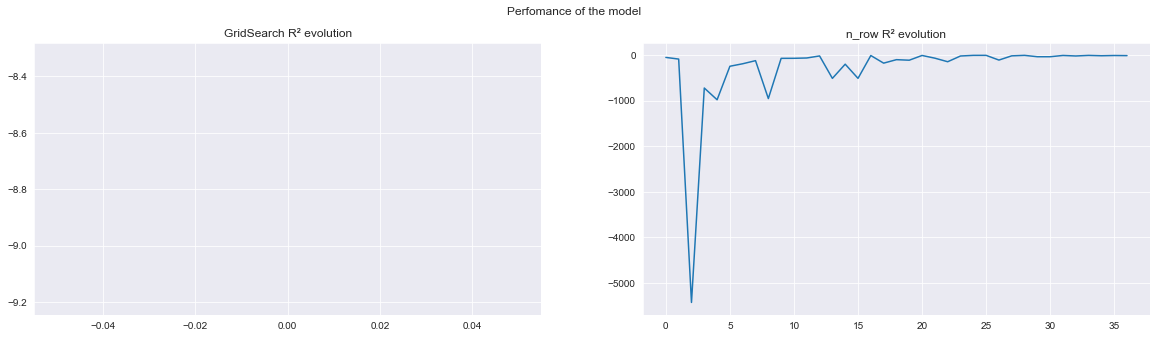

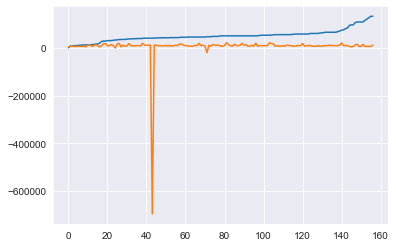

lyon


Model Report

Coefs : [5103.55230445  -11.74132652   24.68279379   91.29452567 4933.96576629
 1140.10288355   57.43510204 1243.53668012 5863.46365345  -62.81676272
    0.            0.         7729.91498954]

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0.1, 'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'l1'}

R2 : -0.49883492083365844
AR2 : -1.07191886115241
MAE/MEAN : 0.5799480228355247
MSE/MEAN² : 0.6915561455809965
RMSE/MEAN : 0.8315985483278554


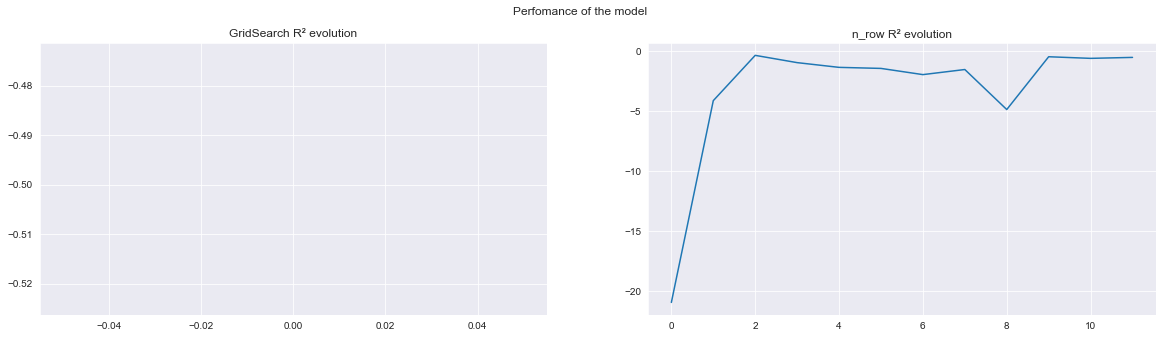

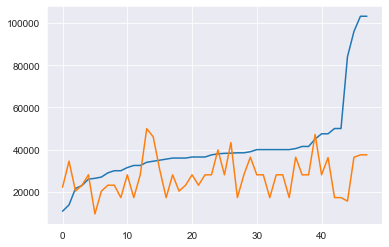

toulouse


Model Report

Coefs : [2352.71148366    9.37849427    0.           74.33788175 5072.29850836
  613.03086868    0.            0.         5341.90118492   78.09550177
    0.            0.         5322.88905157]

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.001, 'eta0': 1e-05, 'l1_ratio': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_loss', 'penalty': 'l1'}

R2 : -2.1305266748626996
AR2 : -6.200211352184208
MAE/MEAN : 0.8591304282883041
MSE/MEAN² : 1.0260741444640344
RMSE/MEAN : 1.01295317979857


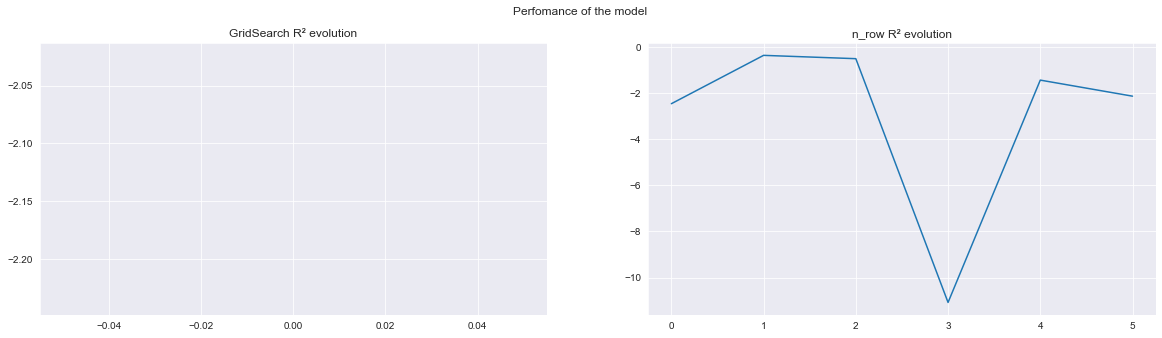

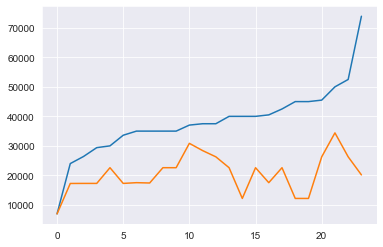

nantes


Model Report

Coefs : [5874.62243955  223.92780777   20.82331083    7.42829244 1786.33364498
   91.23853341   32.8592347    91.93661059 2338.2630432    20.66471422
    0.            0.         2429.97025207]

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.001, 'eta0': 0.05, 'l1_ratio': 0.1, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'penalty': 'l1'}

R2 : -7.742890461539872
AR2 : -10.268614372651392
MAE/MEAN : 1.0866869898039524
MSE/MEAN² : 2.3576404011634002
RMSE/MEAN : 1.5354609735071094


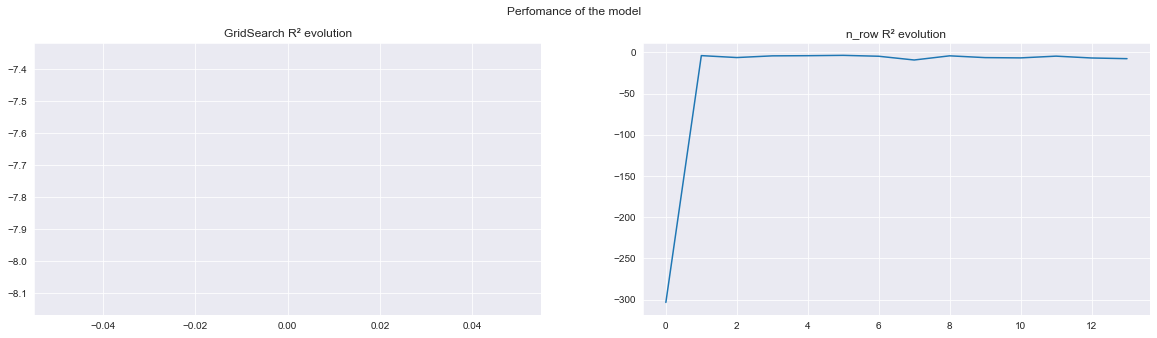

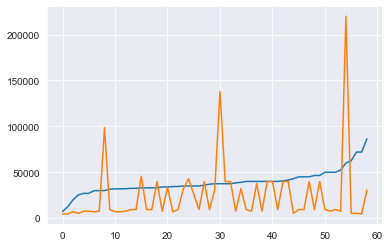

bordeaux


Model Report

Coefs : [176.67687718   2.26556064   0.           0.         105.65600864
   0.           0.           0.         118.76411232   0.
   0.           0.         111.27023456]

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.05, 'eta0': 0.05, 'l1_ratio': 0.1, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'penalty': 'l1'}

R2 : -9.724049618468941
AR2 : -17.924793444356954
MAE/MEAN : 19.733201253841
MSE/MEAN² : 441.6213923121197
RMSE/MEAN : 21.014789846965392


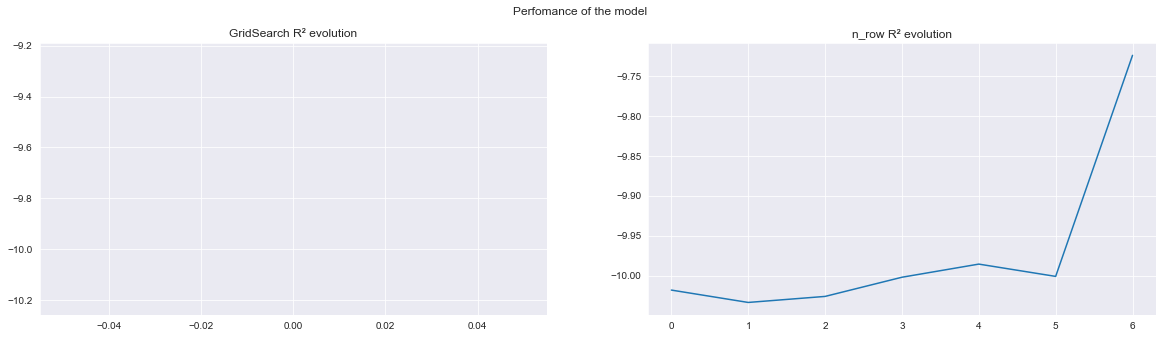

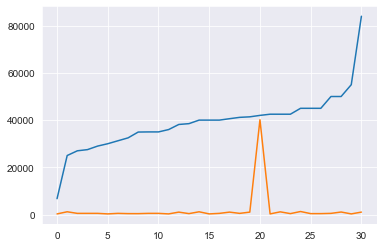

In [22]:
features = list(df.columns[1:14])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['coefs'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# With query

In [ ]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, coefs = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'coefs':coefs})

0/1 - 0.00 - nantes
Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 328 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 2416 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 3866 tasks      | elapsed:  1.0min


In [ ]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['coefs'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# Without ratings

# Paris work 

In [28]:
df = pd.read_csv('csv/paris.csv')
df = df[df['salary_mean']>1000]
df.info()
X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 522
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   salary_mean                  521 non-null    float64
 1   rating_mean                  521 non-null    float64
 2   rating_count                 521 non-null    int64  
 3   contract_contrat pro         521 non-null    int64  
 4   contract_intérim             521 non-null    int64  
 5   contract_temps plein         521 non-null    int64  
 6   contract_indépendant         521 non-null    int64  
 7   contract_cdd                 521 non-null    int64  
 8   contract_temps partiel       521 non-null    int64  
 9   contract_cdi                 521 non-null    int64  
 10  contract_stage               521 non-null    int64  
 11  contract_commission          521 non-null    int64  
 12  contract_apprentissage       521 non-null    int64  
 13  mode_an             

## without query

In [29]:
features = list(df.columns[1:14])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg='paris2')
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 750, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 6, 'subsample': 1.0, 'gamma': 0}

R2 : 0.46432326689241843
AR2 : 0.41562538206445654
MAE/MEAN : 0.20938036971185264
MSE/MEAN² : 0.11776910251282924
RMSE/MEAN : 0.3431750318901846


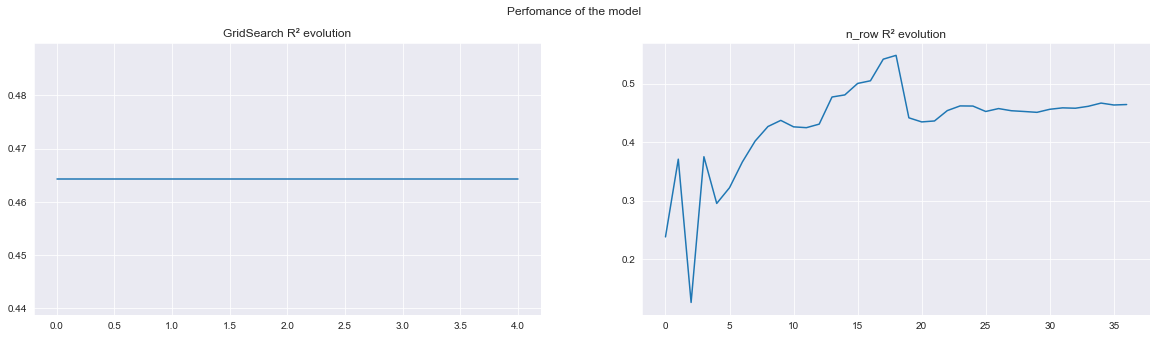

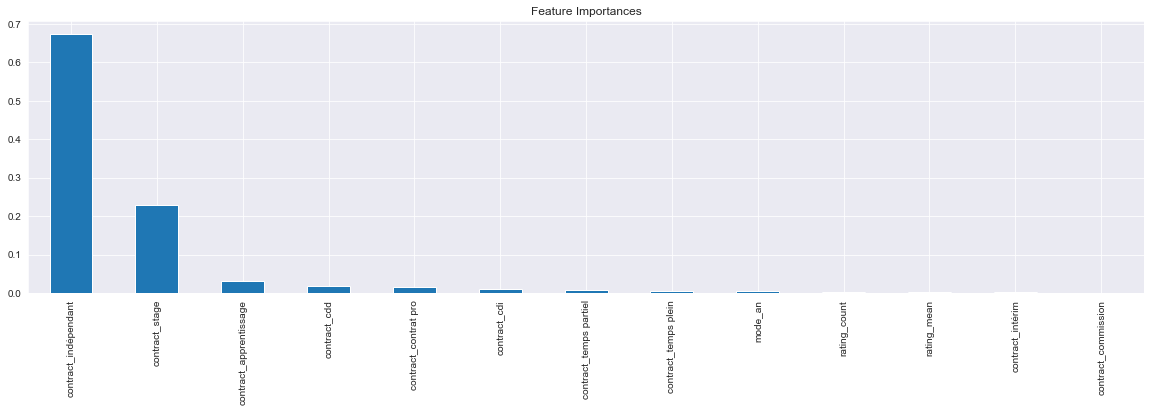

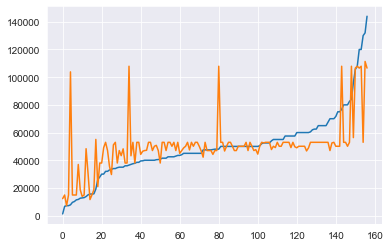

In [30]:
features = list(df.columns[1:14])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)

## with query

In [31]:
features = list(df.columns[1:14]) + list(df.columns[18:])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg=key)
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 650, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 6, 'subsample': 1.0, 'gamma': 0}

R2 : 0.47521845706348786
AR2 : 0.41103654174031734
MAE/MEAN : 0.21727516192985188
MSE/MEAN² : 0.1192465713441748
RMSE/MEAN : 0.34532096858455436


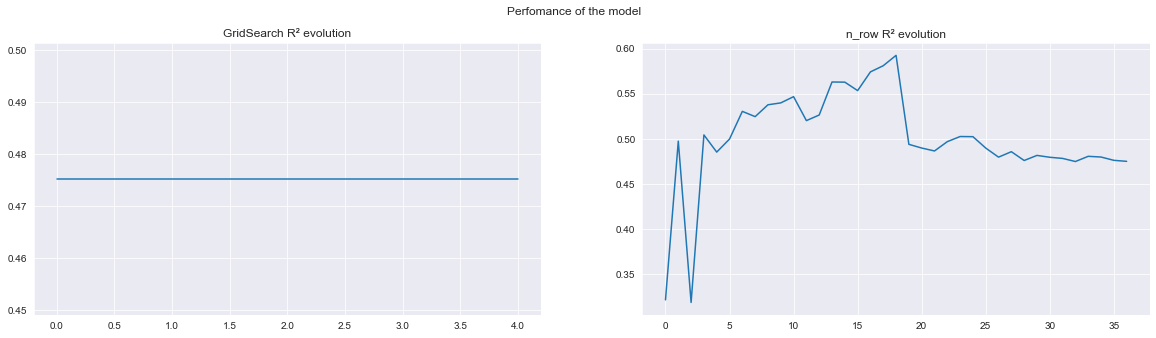

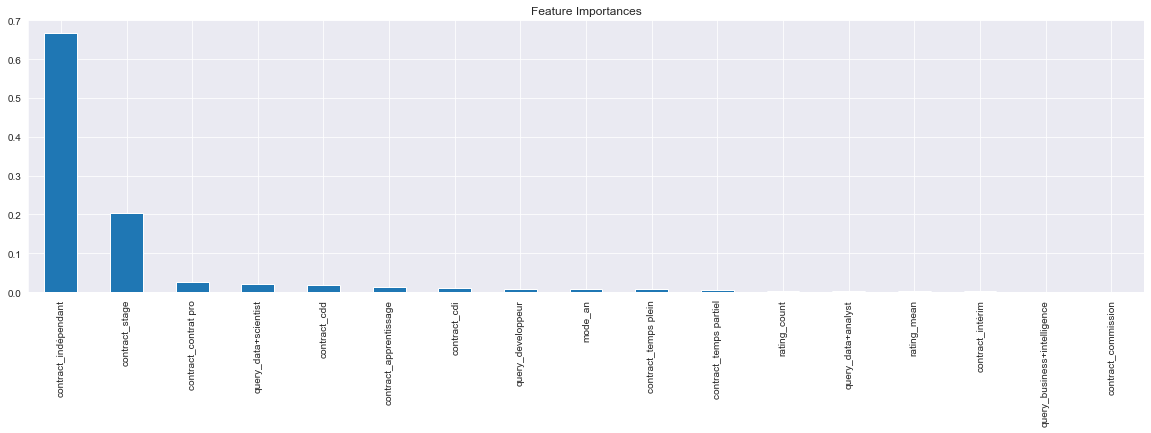

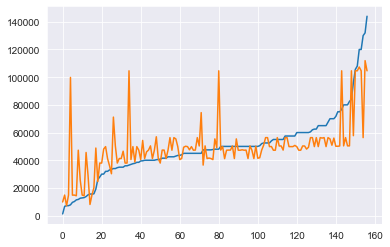

In [32]:
features = list(df.columns[1:14]) + list(df.columns[18:])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)